<a href="https://colab.research.google.com/github/turtlenoise/hacking_the_kidney/blob/main/hacking_the_kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --force-reinstall --no-deps albumentations

     |████████████████████████████████| 81kB 6.2MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import os
import gc
from PIL import Image
import operator
# from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/kidney/hubmap*

/content/gdrive/MyDrive/kidney/hubmap-256x256.zip


In [ ]:
!unzip /content/gdrive/MyDrive/kidney/hubmap-256x256.zip

In [8]:
!ls -la ./masks | wc -l

9583


In [ ]:
!ls -la ./train | wc -l

9583


In [ ]:
# returns a list containing (i,j) coordinates of pixels where glomerulis are found.
def locateGlomeruliPixels(fullPath):
	glomeruliPixels = []

	image = Image.open(fullPath)
	pixelAccess = image.load()

	processedMask = Image.new(image.mode, image.size)
	processedMaskPixels = processedMask.load()
	for i in range(processedMask.size[0]):
	    for j in range(processedMask.size[1]):        
	        if (pixelAccess[i,j] == 1):
	        	processedMaskPixels[i,j] = 256
	        	glomeruliPixels.append((i,j))
	        else:
	        	processedMaskPixels[i,j] = 0        	
	return glomeruliPixels

In [ ]:
def visualiseHighlightedGlomeruli(fullPath, glomeruliPixels):
	image = Image.open(fullPath)
	pixelAccess = image.load()

	processedImage = Image.new(image.mode, image.size)
	processedImagePixels = processedImage.load()
	for i in range(processedImage.size[0]):
	    for j in range(processedImage.size[1]):        
	        if ((i,j) not in glomeruliPixels):
	        	# print(pixelAccess[i,j])
	        	processedImagePixels[i,j] = tuple(map(operator.add, pixelAccess[i,j], (-80,-80,-80)))
	        else:
	        	processedImagePixels[i,j] = pixelAccess[i,j]

	return processedImage

./masks/4ef6695ce_0862.png


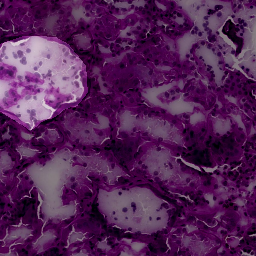

In [ ]:
maskDirectoryPath = './masks/'
imageDirectoryPath = './train/'
maskImageName = os.listdir(maskDirectoryPath)[1000]
fullPath = maskDirectoryPath + maskImageName
print(fullPath) 
glomeruliPixels = locateGlomeruliPixels(fullPath)
fullPath = imageDirectoryPath + maskImageName
processedImage = visualiseHighlightedGlomeruli(fullPath, glomeruliPixels)
processedImage

./masks/c68fe75ea_1286.png


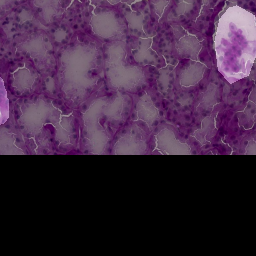

In [ ]:
maskImageName = os.listdir(maskDirectoryPath)[2000]
fullPath = maskDirectoryPath + maskImageName
print(fullPath) 
glomeruliPixels = locateGlomeruliPixels(fullPath)
fullPath = imageDirectoryPath + maskImageName
processedImage = visualiseHighlightedGlomeruli(fullPath, glomeruliPixels)
processedImage

In [5]:
def deleteNoGlomeruliImages(directory):
  for filename in os.listdir(directory):
    maskImage = './masks/' + filename
    actualImage = './train/' + filename

    image = Image.open(maskImage)
    pixelAccess = image.load()

    processedMask = Image.new(image.mode, image.size)
    processedMaskPixels = processedMask.load()
    noGlomeruli = True
    for i in range(processedMask.size[0]):
        for j in range(processedMask.size[1]):        
            if (pixelAccess[i,j] == 1):
              noGlomeruli = False
    if (noGlomeruli):
      os.remove(maskImage)
      os.remove(actualImage)

In [6]:
deleteNoGlomeruliImages('./masks/')

In [7]:
!ls -la ./masks | wc -l

3715


In [ ]:
!ls -la ./train | wc -l

3715


**Hacking The Kidney**

We can see the glomeruli at the left on the first image and at the top in the second image.
The task is to train a model which can predict from a kidney image whether or not a glomeruli is present or not.

*kidney image inputs -> target glomeruli mask outputs.*

In [26]:
transform = A.Compose([
        # A.Resize(256, 256, p=1.0),
        # A.HorizontalFlip(),
        # A.VerticalFlip(),
        # A.RandomRotate90(),
        # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
        #                  border_mode=cv2.BORDER_REFLECT),
        ToTensorV2()
    ], p=1.0)

transform = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=256, width=256, p=0.5),
        A.PadIfNeeded(min_height=256, min_width=256, p=0.5)
    ], p=1),    
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    # ToTensorV2()
])

In [23]:
def convertImagesToTensor(img, dtype:np.dtype=np.float32):
    if img.ndim==2: 
        img=np.expand_dims(img, 2)
    img=np.transpose(img, (2, 0, 1))
    return torch.from_numpy(img.astype(dtype, copy=False))

In [35]:
class HuBMAPDataset(Dataset):
    def __init__(self,df, transform=True):
        ids = df.id.values
        #kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        #ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir('./train') if fname.split('_')[0] in ids]
        self.transform = transform
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join('./train',fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join('./masks',fname),cv2.IMREAD_GRAYSCALE)
        
        random.seed(11)
        transformed = transform(image=img,mask=mask)
        img,mask = transformed['image'],transformed['mask']
            
        img = img/255
        
        return convertImagesToTensor(img), convertImagesToTensor(mask)

In [10]:
!unzip /content/gdrive/MyDrive/kidney/train.csv.zip

Archive:  /content/gdrive/MyDrive/kidney/train.csv.zip
  inflating: train.csv               


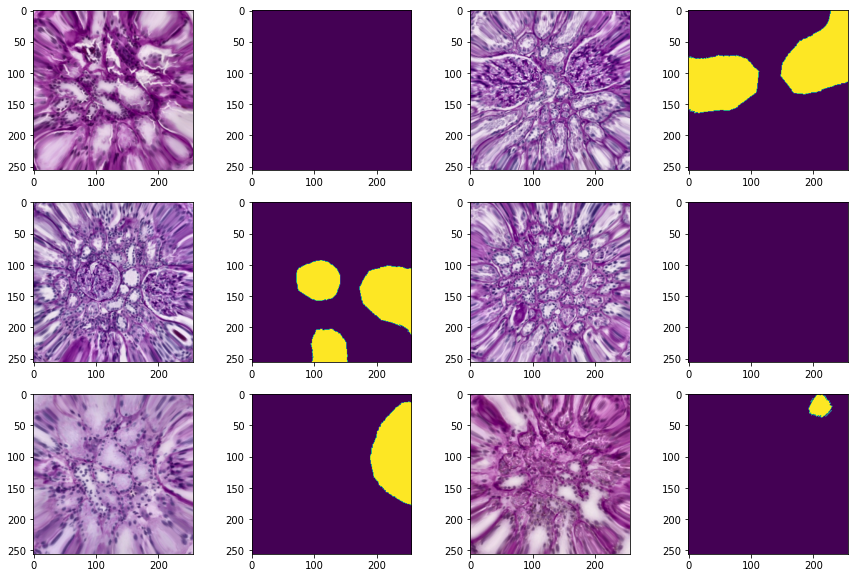

In [36]:
train_df = pd.read_csv('./train.csv')

train_dataset = HuBMAPDataset(train_df, transform=True)
plt.figure(figsize=(15,10))
for i in range(6):
    image, mask = train_dataset[i*9]
    plt.subplot(3,4,2*i+1)
    # (1,2,0) for regaining the original color.
    plt.imshow(np.transpose((image), (1,2,0)))
    # plt.imshow(image)
    plt.subplot(3,4,2*i+2)
    # plt.imshow(mask)
    plt.imshow(mask[0])

In [ ]:
image, mask = train_dataset[42]

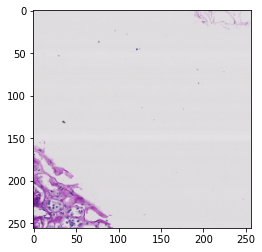

In [ ]:
plt.imshow(np.transpose(image,(1,2,0)))

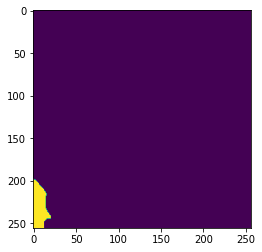

In [ ]:
plt.imshow(mask)

In [37]:
def train_one_epoch(fold, model, dataloader_train, dataloader_valid, optimizer):
    #training phase
    model.train()
    train_loss = 0
    for i, (imgs, masks) in enumerate(dataloader_train):
        optimizer.zero_grad()
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        #forward pass
        outputs = model(imgs)
        #cal loss and backward
        loss = diceLoss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(dataloader_train)
    
    #validating phase
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader_valid):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)
            loss = diceLoss(outputs, masks)
            valid_loss += loss.item()
    valid_loss /=len(dataloader_valid)
    print(f'FOLD: {fold + 1}, EPOCH: {epoch + 1} - train loss: {train_loss} -  valid_loss: {valid_loss}')
    return train_loss, valid_loss

In [87]:
batch_size = 12
validation_split = .2
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validationDataLoader = DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [85]:
xb, yb = next(iter(trainDataLoader))
xb.shape, yb.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

In [15]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
def UnetDenseNet():
    return smp.Unet(
    encoder_name='densenet201',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1)

     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 245kB 41.2MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=b6fa50e83923e4e113d24d80a437902d95cf9572ad8965ed82607b15c01e428d
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=bf08654cb90a808712d9c5adff4b2590adc467081f71753365bfd701b56631c4
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [86]:
from tqdm import tqdm_notebook as tqdm
best_valid_loss = 0
fold = 0
nfolds = 1
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 5

for fold in range(nfolds):

    # model = UnetDenseNet().to(DEVICE)
    model = UNET(3,1).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loss = 0
    valid_loss = 0
    trainLossList = []
    validationLossList = []
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_loss, valid_loss = train_one_epoch(fold, model, trainDataLoader, validationDataLoader, optimizer)
        trainLossList.append(train_loss)
        validationLossList.append(valid_loss)
      
    torch.save(model.state_dict(), f'model_fold_{fold}.pth')
    if best_valid_loss == 0:
        best_valid_loss = valid_loss
    if best_valid_loss >= valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'best_unet_model.pth')
    torch.cuda.empty_cache()
    gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


RuntimeError: ignored

In [76]:
import torch
from torch import nn
# https://arxiv.org/abs/1505.04597
# https://www.nature.com/articles/s41598-019-53797-9
# https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 256)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [51]:
xb, yb = next(iter(trainDataLoader))
xb.shape, yb.shape

(torch.Size([12, 256, 256, 3]), torch.Size([12, 256, 256]))

In [18]:
def diceLoss(inputs, targets, smooth=1):
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return 1 - dice

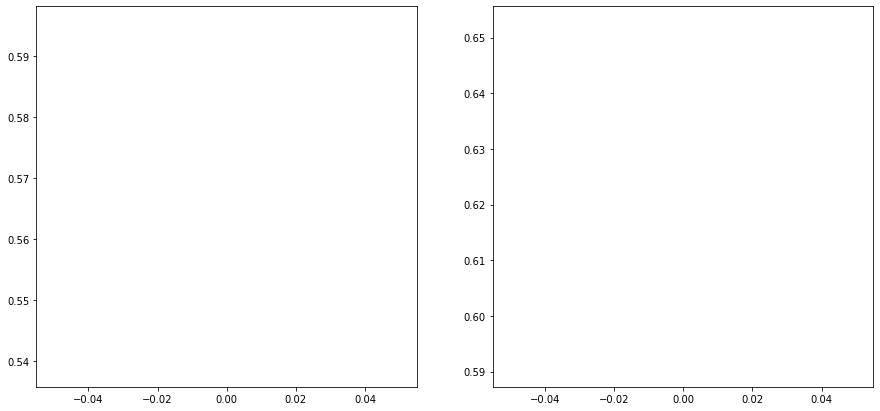

In [73]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(train_loss)
ax[1].plot(valid_loss)
plt.show()

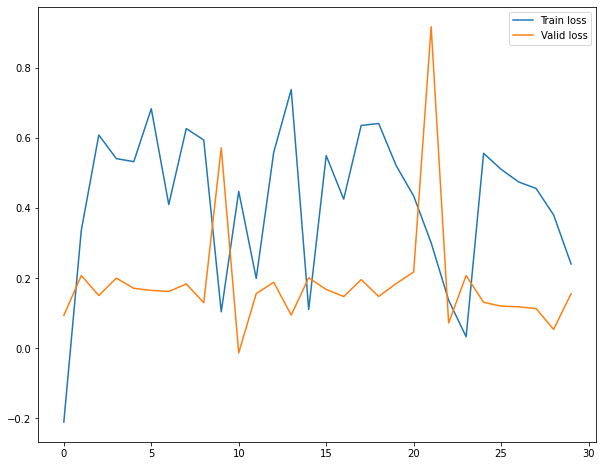

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

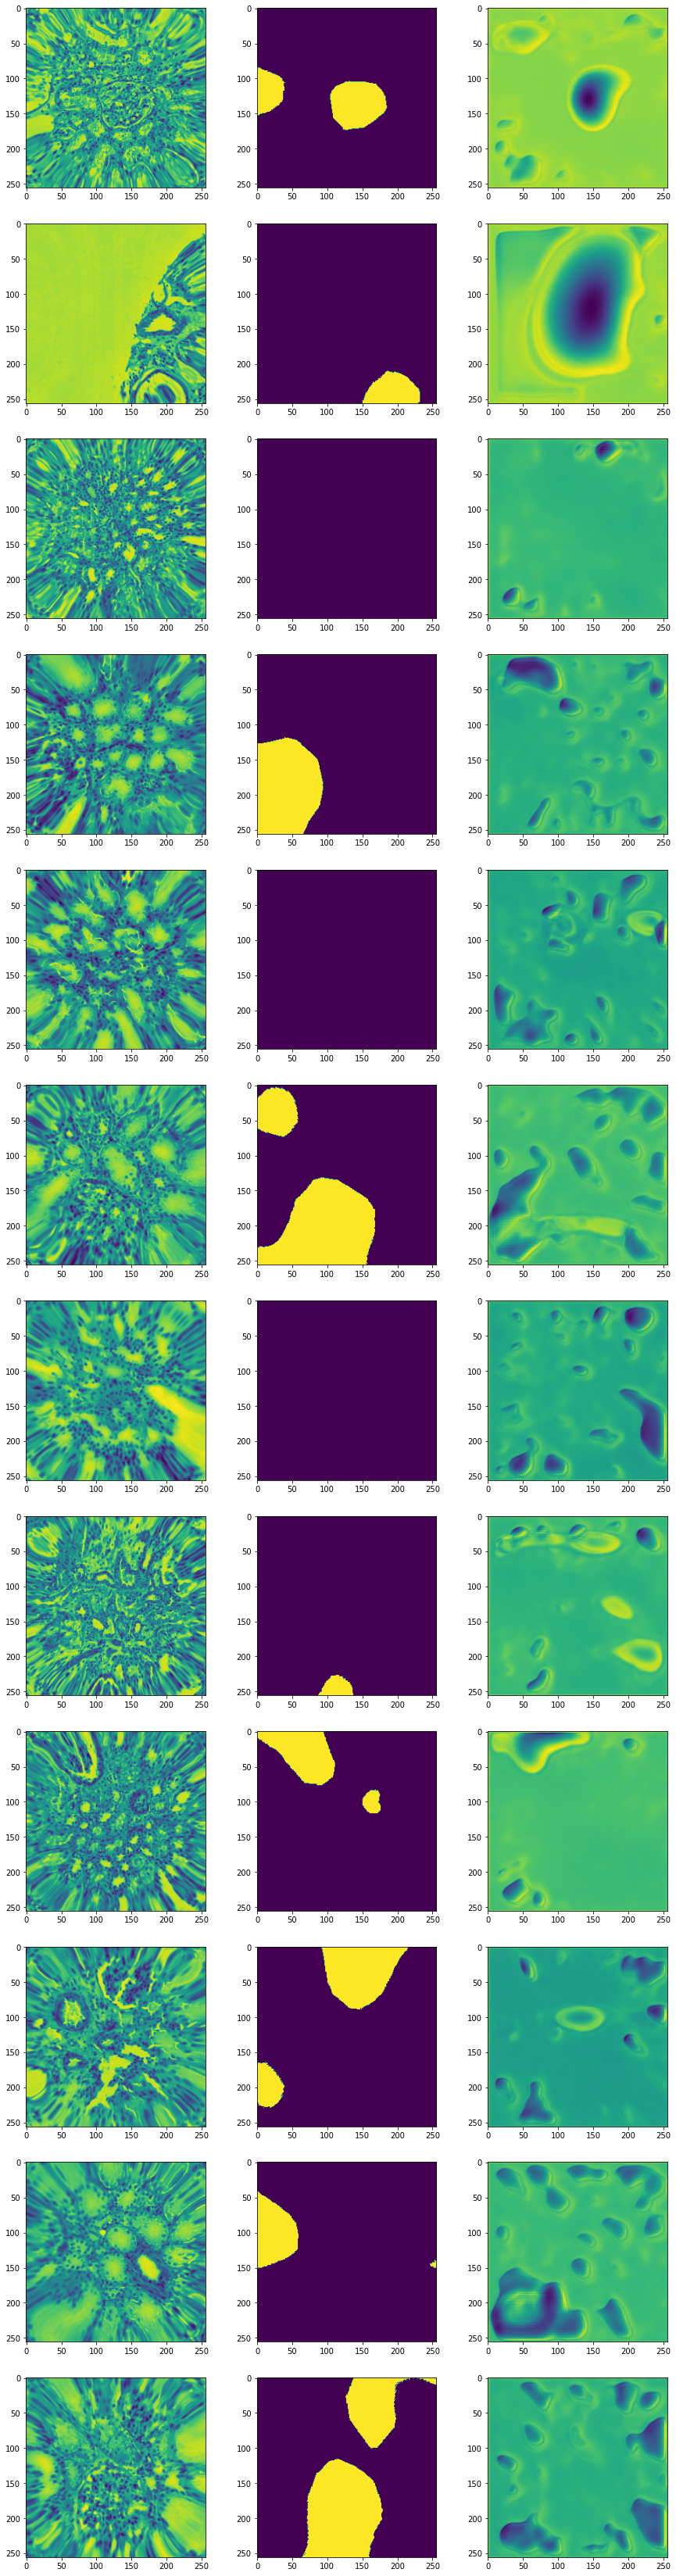

In [70]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    xb, yb = next(iter(trainDataLoader))
    with torch.no_grad():
        predb = model(xb.cuda())

    original = np.squeeze(xb.cpu()[1][0]) # you can give axis attribute if you wanna squeeze in specific dimension
    ax[i,0].imshow(original)
    originalMask = np.squeeze(yb.cpu()[1]) # you can give axis attribute if you wanna squeeze in specific dimension
    ax[i,1].imshow(originalMask)
    predictedMask = np.squeeze(predb.cpu()[1]/255) # you can give axis attribute if you wanna squeeze in specific dimension
    ax[i,2].imshow(predictedMask)
